## 6/7/24

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Definir las constantes
g = 9.8 # gravedad [m/s^2]
p_atm = 101325 # Presión atmosférica [Pa]
beta = 3.67e-3 # Coeficiente de expansion termica [1/K]
T_w = 80.0 + 273.0 # Temperatura de la pared [K]
T_a = 20.0 + 273.0 # Temperatura ambiente [K]
delta_T = T_w - T_a
lambda_f = 0.04 # Coeficiente de friccion [adimensional]
R = 10.0 # Radio de la tuberia [m]
L = 100.0 # Longitud de la tuberia [m]
alpha = 2.2e-5 # Coeficiente de difusividad [m^2/s]
rho_0 = 1.0 # Densidad [kg/m^3]
Cp = 1.012 # Capacidad calorifica [J/(kg K)]
u_c = np.sqrt(g * beta * L * delta_T) # Velocidad caracteristica [m/s]
k = 0.024 # Conductividad termica [W/(m K)]
nu = 1.71e-5 # Viscosidad [Pa s]
Ra_D = (g * beta * delta_T * (2 * R)**3)/ nu**2 # Numero de Rayleigh
Nu = (576/(Ra_D * 2 * R /L)**2 + 2.873/(Ra_D * 2 * R /L)**(1/2))**(-1/2)# Numero de Nusselt
h_v = (k * Nu)/ (2 * R * L)
Pi_0 = (rho_0 * g * L) / (p_atm) 
Pi_d = (rho_0 * u_c**2) / (2 * p_atm)
phi = beta * delta_T
LAMBDA = (lambda_f * u_c**2) / (8 * R * g)
gamma = (h_v * L) / (rho_0 * Cp * u_c)
delta = alpha / (L * u_c)
t_c_1 = L/ u_c # tiempo caracteristico [s] primera definición
t_c_2 = u_c / g # tiempo caracteristico [s] segunda definición

## Simulación con variación espacial en la velocidad ($t_c = \frac{L}{u_c}$)

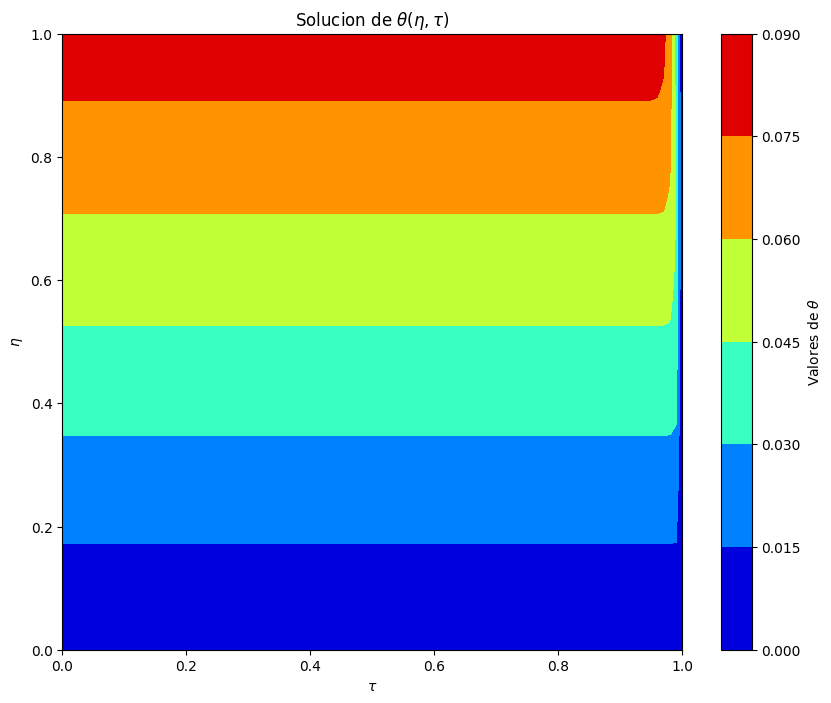

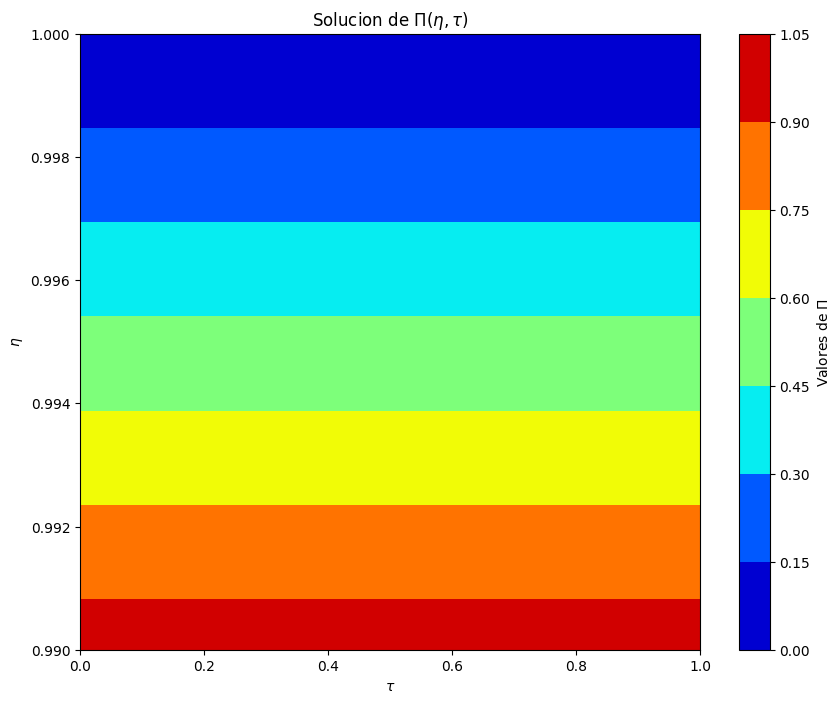

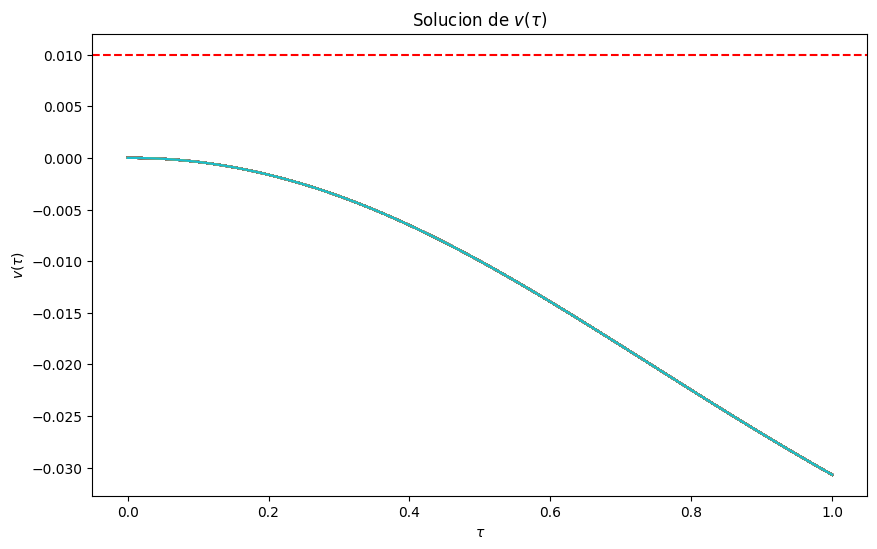

In [46]:
# Definición de variables y condiciones iniciales
N = 100  # Número de puntos en la dirección temporal
M = 100  # Número de puntos en la dirección vertical
eta = np.linspace(0, 1, M)  # Coordenada vertical adimensional
tau = np.linspace(0, 1, N)  # Coordenada temporal adimensional
deta = (eta[-1] - eta[0])/ M
dtau = (tau[-1] - tau[0])/ N
v = np.zeros((N, M))  # Velocidad adimensional
theta = np.zeros((N, M))  # Temperatura adimensional
Pi = np.zeros((N, M))  # Presión adimensional

# Condiciones iniciales
v[0, :] = 0.0  # Velocidad inicial cero
theta[0, :] = 0.0  # Temperatura inicial uniforme
Pi[0, :] = 1.0  # Presión inicial uniforme

# Simulación numérica
for i in range(N-1):
    for j in range(M-1):

        Pi[i, j] = 1.0 - Pi_0 * eta[i] - Pi_d * v[i, j] ** 2
        Pi[i, j + 1] = 1.0 - Pi_0 * eta[i] - Pi_d * v[i, j + 1] ** 2

        a = v[i, j] + dtau * (g * t_c_1 / u_c) * (
            - (1/Pi_0) * (Pi[i, j + 1] - Pi[i, j]) / (eta[j + 1] - eta[j])
            - phi * theta[i, j]
            - LAMBDA * v[i, j] ** 2
        )

        v[i + 1, :] = np.ones(M) * a

        theta[i + 1, j] = theta[i, j] + dtau * (u_c * t_c_1 / L) * (
            - v[i, j] * (theta[i, j + 1] - theta[i, j]) / (eta[j + 1] - eta[j])
            + delta * (theta[i, j + 1] - 2 * theta[i, j] + theta[i, j - 1]) / (eta[j + 1] - eta[j]) ** 2
            - gamma * (theta[i, j] - 1)
        )

# Graficar la solucion
T, X = np.meshgrid(np.linspace(tau[0], tau[-1], N), np.linspace(eta[0], eta[-1], M))
fig, ax = plt.subplots(figsize=(10,8))
cmap = plt.get_cmap('jet')  # Seleccionar un mapa de color
contour = ax.contourf(T, X, theta, cmap=cmap)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\eta$')
ax.set_title('Solucion de '+r'$\theta (\eta,\tau)$')

# Agregar la leyenda
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label('Valores de ' + r'$\theta$')

plt.show()

# Graficar la solucion
T, X = np.meshgrid(np.linspace(tau[0], tau[-1], N), np.linspace(eta[0], eta[-1], M))
fig, ax = plt.subplots(figsize=(10,8))
cmap = plt.get_cmap('jet')  # Seleccionar un mapa de color
contour = ax.contourf(T, X, Pi, cmap=cmap)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\eta$')
ax.set_title('Solucion de '+r'$\Pi (\eta,\tau)$')
ax.set_ylim(0.99,1)

# Agregar la leyenda
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label('Valores de ' + r'$\Pi$')

plt.show()


# Graficar la solucion de v(t)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(tau, v, label = r'$v(\tau)$')

# Agregar una linea horizontal en un valor especifico de x
x_linea = 0.01  # Valor de x donde se dibujará la linea horizontal
ax.axhline(y=0.01, color='r', linestyle='--', label = r'$v_0$')

ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$v(\tau)$')
ax.set_title('Solucion de '+r'$v(\tau)$')
#ax.legend()
plt.show()


## Simulación con variación espacial en la velocidad ($t_c = \frac{u_c}{g}$)

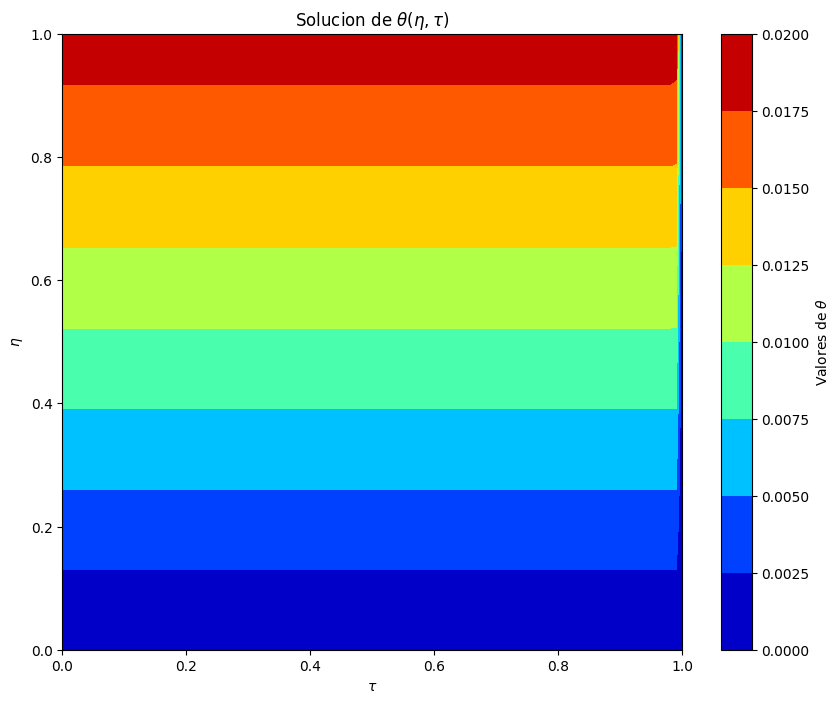

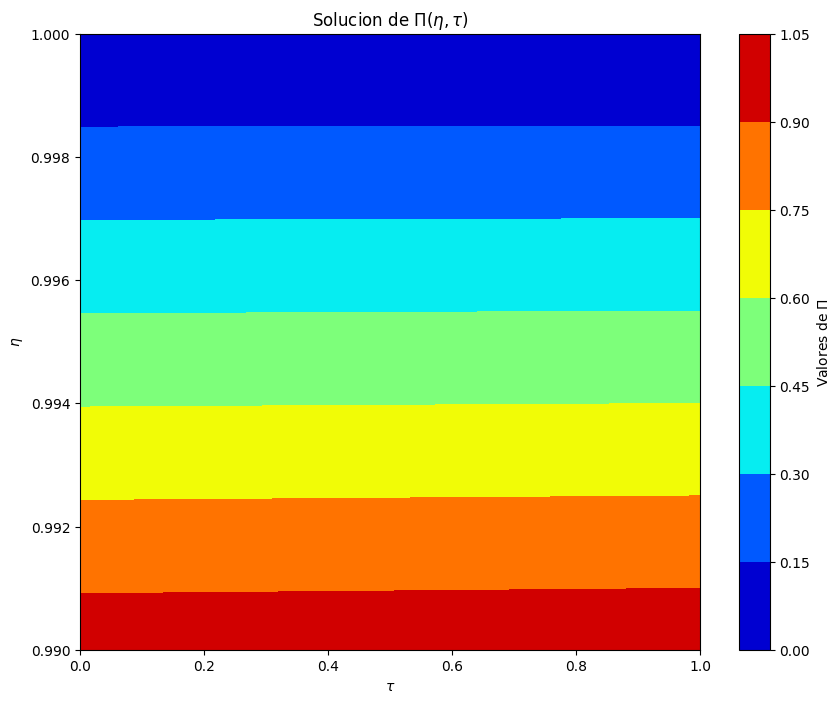

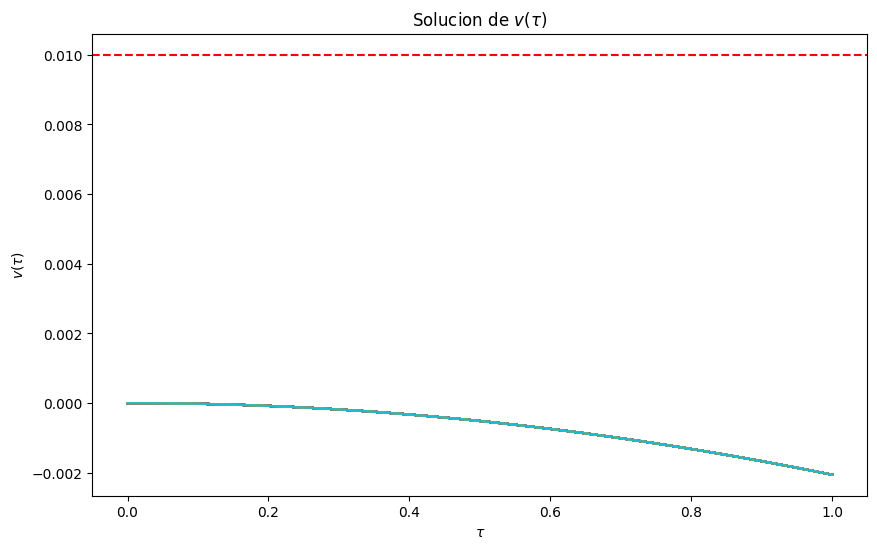

In [43]:
# Definición de variables y condiciones iniciales
N = 100  # Número de puntos en la dirección temporal
M = 100  # Número de puntos en la dirección vertical
eta = np.linspace(0, 1, M)  # Coordenada vertical adimensional
tau = np.linspace(0, 1, N)  # Coordenada temporal adimensional
deta = (eta[-1] - eta[0])/ M
dtau = (tau[-1] - tau[0])/ N
v = np.zeros((N, M))  # Velocidad adimensional
theta = np.zeros((N, M))  # Temperatura adimensional
Pi = np.zeros((N, M))  # Presión adimensional

# Condiciones iniciales
v[0, :] = 0.0  # Velocidad inicial cero
theta[0, :] = 0.0  # Temperatura inicial uniforme
Pi[0, :] = 1.0  # Presión inicial uniforme

# Simulación numérica
for i in range(N-1):
    for j in range(M-1):

        Pi[i, j] = 1.0 + Pi_0 * eta[j] + Pi_d * v[i, j] ** 2
        Pi[i, j + 1] = 1.0 + Pi_0 * eta[j] + Pi_d * v[i, j + 1] ** 2

        a = v[i, j] - dtau * (g * t_c_2 / u_c) * (
            + (1/Pi_0) * (Pi[i, j + 1] - Pi[i, j]) / (eta[j + 1] - eta[j])
            + phi * theta[i, j]
            + LAMBDA * v[i, j] ** 2
        )

        v[i + 1, :] = np.ones(M) * a

        theta[i + 1, j] = theta[i, j] + dtau * (u_c * t_c_2 / L) * (
            - v[i, j] * (theta[i, j + 1] - theta[i, j]) / (eta[j + 1] - eta[j])
            + delta * (theta[i, j + 1] - 2 * theta[i, j] + theta[i, j - 1]) / (eta[j + 1] - eta[j]) ** 2
            - gamma * (theta[i, j] - 1)
        )

# Graficar la solucion
T, X = np.meshgrid(np.linspace(tau[0], tau[-1], N), np.linspace(eta[0], eta[-1], M))
fig, ax = plt.subplots(figsize=(10,8))
cmap = plt.get_cmap('jet')  # Seleccionar un mapa de color
contour = ax.contourf(T, X, theta, cmap=cmap)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\eta$')
ax.set_title('Solucion de '+r'$\theta (\eta,\tau)$')

# Agregar la leyenda
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label('Valores de ' + r'$\theta$')

plt.show()

# Graficar la solucion
T, X = np.meshgrid(np.linspace(tau[0], tau[-1], N), np.linspace(eta[0], eta[-1], M))
fig, ax = plt.subplots(figsize=(10,8))
cmap = plt.get_cmap('jet')  # Seleccionar un mapa de color
contour = ax.contourf(T, X, Pi, cmap=cmap)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$\eta$')
ax.set_title('Solucion de '+r'$\Pi (\eta,\tau)$')
ax.set_ylim(0.99,1)

# Agregar la leyenda
cbar = fig.colorbar(contour, ax=ax)
cbar.set_label('Valores de ' + r'$\Pi$')

plt.show()


# Graficar la solucion de v(t)
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(tau, v, label = r'$v(\tau)$')

# Agregar una linea horizontal en un valor especifico de x
x_linea = 0.01  # Valor de x donde se dibujará la linea horizontal
ax.axhline(y=0.01, color='r', linestyle='--', label = r'$v_0$')

ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$v(\tau)$')
ax.set_title('Solucion de '+r'$v(\tau)$')
#ax.legend()
plt.show()
